## Drop Out Prediction Models
In this part we will predict whethwe a student will drop out or not. We can think of this as a classification problem. Where we will try different models and investigate which one of them performs better:

---
Import the dataset and split the data into training and validation set, as well as the year for which we want to make the predictions:

In [126]:
from DATASET import clean_df
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = clean_df.copy()
df = df.dropna(subset=['nota_assignatura'])

# Separate current year data (to predict)
df_train = df[df['curs_academic'] != '2023/24'].copy()
df_pred_target = df[df['curs_academic'] == '2023/24'].copy()

In [127]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define target variable (abandonament) and input features (droping target from features)
X_train_full = df_train.drop(columns=['abandonament'])
y_train_full = df_train['abandonament']

# Split train into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,
    stratify=y_train_full,
    random_state=42
)

# Data to predict
X_predict = df_pred_target.drop(columns=['abandonament'])
y_predict = df_pred_target['abandonament']   # Ground truth for 2023/24

# Select categorical columns to encode
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

# Identify categorical and numeric columns
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)

Define some functions to evaluate the models and plot results:

In [128]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def evaluate_classification_models(model, X_test, y_test):

    y_pred = model.predict(X_test)
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_classification_results(y_true, y_pred, y_proba=None, labels=None):

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=labels, yticklabels=labels)
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # ROC Curve (if probabilities provided)
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        roc_auc = auc(fpr, tpr)
        axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        axes[1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].set_title('Receiver Operating Characteristic')
        axes[1].legend(loc='lower right')
    else:
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

In [130]:
from sklearn.model_selection import cross_val_score

def cross_validation(pipeline, X_train, y_train, scoring='f1', cv=5):
    scores = cross_val_score(pipeline, X_train, y_train, scoring=scoring, cv=cv)
    print("Cross-validated F1 scores:", scores)
    print("Mean F1:", scores.mean())

Let's plot the distribution of our classes to understand the data we are dealing with:

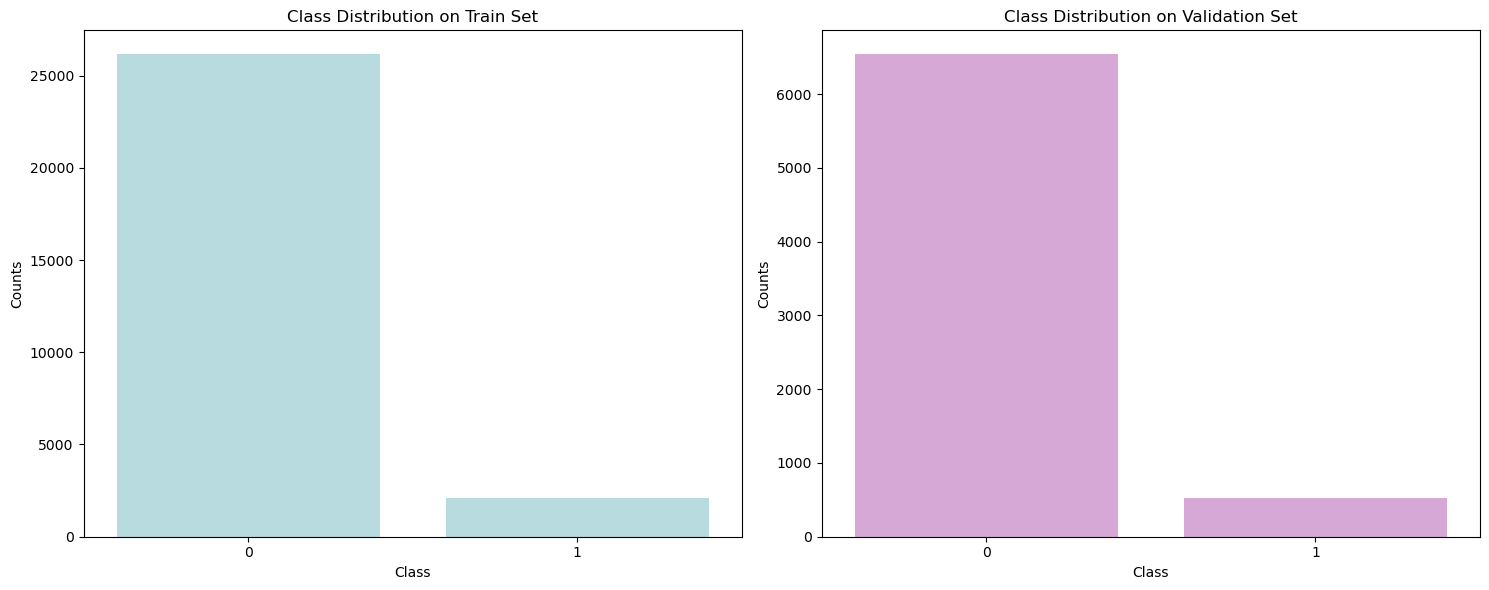

In [131]:
data_train = {'0': np.sum(y_train == 0), '1': np.sum(y_train == 1)}

df_train = pd.DataFrame({
    'Class': ['0', '1'],
    'Counts': [data_train['0'], data_train['1']]
})

data_val = {'0': np.sum(y_val == 0), '1': np.sum(y_val == 1)}

df_val = pd.DataFrame({
    'Class': ['0', '1'],
    'Counts': [data_val['0'], data_val['1']]
})


fig, axes = plt.subplots(1, 2, figsize=(15, 6))  
# Plot train set distribution
sns.barplot(data=df_train, x='Class', y='Counts', color='powderblue', ax=axes[0])
axes[0].set_title("Class Distribution on Train Set")

# Plot validation set distribution
sns.barplot(data=df_val, x='Class', y='Counts', color='plum', ax=axes[1])
axes[1].set_title("Class Distribution on Validation Set")

plt.tight_layout()  
plt.show()

As we can see the classes are not evenly distributed, we have much more negative cases than positive ones, both in training and validation sets. Knowing this, we will have to take it into account when building the models.

---
### 1. Logistic Regression Model
---

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6538
           1       0.96      1.00      0.98       526

    accuracy                           1.00      7064
   macro avg       0.98      1.00      0.99      7064
weighted avg       1.00      1.00      1.00      7064



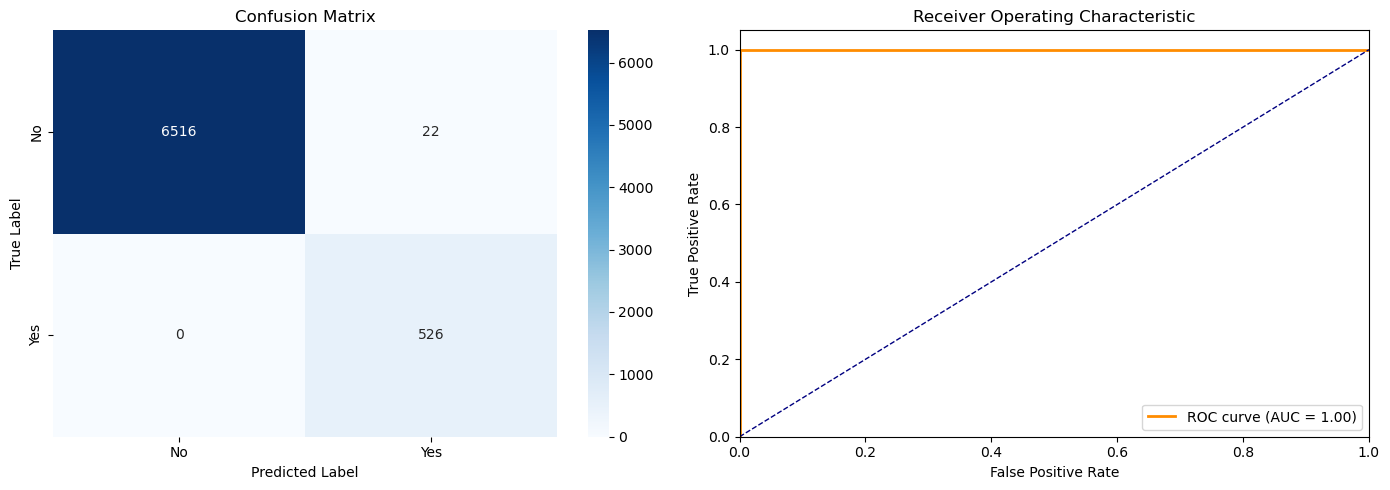

Cross-validated F1 scores: [0.55681206 0.72031873 0.75462185 0.84880637 0.21374046]
Mean F1: 0.6188598920736906


In [132]:
from sklearn.linear_model import LogisticRegression

# Define the pipeline with Logistic Regression
LR_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=200, class_weight='balanced'))  
])

# Train the model
LR_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = LR_pipeline.predict(X_val)

# Evaluate the model
print(classification_report(y_val, y_pred))

y_pred = LR_pipeline.predict(X_val)
y_proba = LR_pipeline.predict_proba(X_val)[:, 1]  # Probabilities for positive class

# Plot confusion matrix as well as ROC-curve
plot_classification_results(y_val, y_pred, y_proba, labels=['No', 'Yes'])

# Use cross validation
cross_validation(LR_pipeline, X_train_full, y_train_full)

> Initially the number of false negatives was higher than the number of false positives. One of the reasons behind this could be that the classes are unbalanced, therefore the model learned to output with a higher probability the most frequent class, which is 0. In order to avoid this, and because for our particular application we are more interested in reducing false negatives than false positives. We were able to change this results by using the parameter `class_weight='balanced'`. When it is specified the model weights errors on the minority class automatically higher, reducing a bit the effect of the unbalanced classes.

---
### 2. SVM: Support Vector Machine
---

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6538
           1       1.00      0.92      0.95       526

    accuracy                           0.99      7064
   macro avg       0.99      0.96      0.98      7064
weighted avg       0.99      0.99      0.99      7064



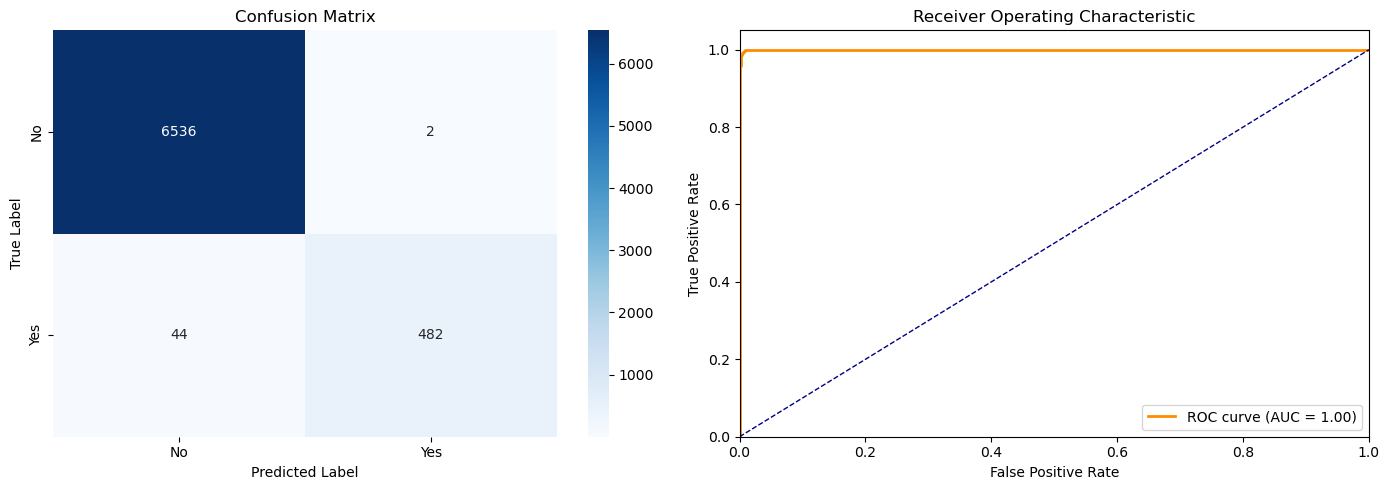

In [133]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Define the pipeline with preprocessing and SVM classifier
SVM_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # your preprocessing pipeline
    ('classifier', SVC())             # default kernel='rbf', probability=False
])

# Train the model
SVM_pipeline.fit(X_train, y_train)

# Predict labels on validation set
y_pred = SVM_pipeline.predict(X_val)

# Evaluate performance
print(classification_report(y_val, y_pred))

# Get decision function scores for ROC curve
y_scores = SVM_pipeline.decision_function(X_val)

# Plot confusion matrix + ROC curve using your plotting function
plot_classification_results(y_val, y_pred, y_scores, labels=['No', 'Yes'])